In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
import numpy as np
import os
import matplotlib as mpl

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch

from sbi.inference import NPE, DirectPosterior
from sbi.neural_nets import posterior_nn
from sbi.inference.posteriors import EnsemblePosterior

from pyloric import simulate, create_prior, summary_stats

from paper.colors import colors

/Users/michaeldeistler/anaconda3/envs/sbitutorial/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
x_o = np.load("../results/xo_11deg.npy", allow_pickle=True)

# First row

### Panel a

Panel a shows the pyloric network illustration.

### Panel b

Panel b shows the observation with indicated summary statistics

### Panel c

Panel c shows data preprocessing:

- prior predictive where first neuron does not spike  
- prior predictive where one neuron has very long burst  
- histogram of some summary stats  

### Panel d

Panel d shows the posterior marginals.

In [4]:
prior = create_prior(as_torch_dist=True)

posteriors = []
for i in range(5):
    with open(f"../results/density_estimator_seed{i}.pkl", "rb") as handle:
        density_estimator = pickle.load(handle)
    prior = create_prior(as_torch_dist=True)
    posterior = DirectPosterior(density_estimator, prior)
    posteriors.append(posterior)
posterior = EnsemblePosterior(posteriors)

In [5]:
limits = torch.stack([
    prior.support.base_constraint.lower_bound,
    prior.support.base_constraint.upper_bound,
]).T

In [6]:
_ = torch.manual_seed(0)
num_samples = 1_000
posterior_samples = posterior.sample((num_samples,), x=x_o)

posterior_samples -= limits[:, 0]
posterior_samples /= (limits[:, 1] - limits[:, 0])

stds = torch.std(posterior_samples, axis=0)
sorting = torch.argsort(stds, descending=True)

p1 = create_prior()
pars = p1.sample((1,))
column_names = pars.columns
joined = column_names.map(lambda x: f"{"" if x[0] == "Synapses" else f"{x[0]}-"}{x[1]}").tolist()

Drawing 199 posterior samples for 1 observations:   0%|                                                                                    | 0/199 [00:00<?, ?it/s]/Users/michaeldeistler/anaconda3/envs/sbitutorial/lib/python3.12/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(
Drawing 199 posterior samples for 1 observations: 279it [00:00, 3388.77it/s]                                                                                       
Drawing 202 posterior samples for 1 observations: 265it

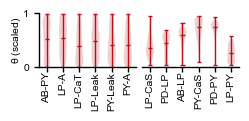

In [7]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    n = 6
    fig, ax = plt.subplots(1, 2, figsize=(2.59, 0.7))
    parts = ax[0].violinplot(
        posterior_samples[:1_000, sorting[:n]].numpy(),
        showmeans=False,
        showmedians=True,
    )
    for pc in parts["bodies"]:
        pc.set_facecolor(colors["theta_shades"][3])  # or any color you like
        pc.set_alpha(0.2)  # optional transparency
        
    # Style median line
    if "cmedians" in parts:
        parts["cmedians"].set_color(colors["theta_shades"][3])

    # Style vertical bars (min to max)
    if "cbars" in parts:
        parts["cbars"].set_color(colors["theta_shades"][3])

    # Style caps (min and max horizontal lines)
    if "cmins" in parts:
        parts["cmins"].set_color(colors["theta_shades"][3])
    if "cmaxes" in parts:
        parts["cmaxes"].set_color(colors["theta_shades"][3])

    ax[0].set_xticks(np.arange(1, n+1))
    ax[0].set_xticklabels([joined[s] for s in sorting[:n]], rotation=90)
    ax[0].set_xlim(0.5, n+0.5)
    ax[0].set_ylim([0, 1])
    ax[0].set_yticks([0, 1])
    ax[0].set_ylabel(r"$\theta$"+" (scaled)", labelpad=0)
    
    parts = ax[1].violinplot(
        posterior_samples[:1_000, sorting[-n:]].numpy(),
        showmeans=False,
        showmedians=True
    )
    for pc in parts["bodies"]:
        pc.set_facecolor(colors["theta_shades"][3])  # or any color you like
        pc.set_alpha(0.2)  # optional transparency
        
    # Style median line
    if "cmedians" in parts:
        parts["cmedians"].set_color(colors["theta_shades"][3])

    # Style vertical bars (min to max)
    if "cbars" in parts:
        parts["cbars"].set_color(colors["theta_shades"][3])

    # Style caps (min and max horizontal lines)
    if "cmins" in parts:
        parts["cmins"].set_color(colors["theta_shades"][3])
    if "cmaxes" in parts:
        parts["cmaxes"].set_color(colors["theta_shades"][3])
    ax[1].spines["left"].set_visible(False)
    ax[1].set_yticks([])
    ax[1].set_xticks(np.arange(1, n+1))
    ax[1].set_xticklabels([joined[s] for s in sorting[-n:]], rotation=90)
    ax[1].set_xlim(0.5, n+0.5)
    ax[0].tick_params(axis="x", pad=0)
    ax[1].tick_params(axis="x", pad=0)

    plt.subplots_adjust(wspace=0.06)
    plt.savefig("../svg/panel_d.svg", bbox_inches="tight", transparent=True)
    plt.show()

### Panel e

Panel e shows a 2D posterior marginal

In [8]:
_ = torch.manual_seed(0)
num_samples = 10_000
posterior_samples = posterior.sample((num_samples,), x=x_o)

Drawing 1951 posterior samples for 1 observations: 1994it [00:00, 20122.13it/s]                                                                                    
Drawing 2029 posterior samples for 1 observations: 2126it [00:00, 21784.60it/s]                                                                                    
Drawing 1971 posterior samples for 1 observations: 2048it [00:00, 26398.89it/s]                                                                                    
Drawing 2035 posterior samples for 1 observations: 2103it [00:00, 26105.78it/s]                                                                                    
Drawing 2014 posterior samples for 1 observations: 2065it [00:00, 27393.81it/s]                                                                                    


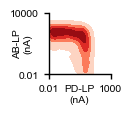

In [9]:
import seaborn as sns
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.8, 0.8))
    sns.kdeplot(
        x=posterior_samples[:10_000, 25],
        y=posterior_samples[:10_000, 24],
        fill=True,
        thresh=0.05,
        levels=5,
        cmap="Reds",
        ax=ax,
    )
    _ = ax.set_xticks([-18.4, -6.9])
    _ = ax.set_xlim([-18.4, -6.9])
    _ = ax.set_xticklabels([0.01, 1_000])
    _ = ax.set_yticks([-18.4, -4.6])
    _ = ax.set_ylim([-18.4, -4.6])
    _ = ax.set_yticklabels([0.01, 10_000])
    _ = ax.set_xlabel("PD-LP\n(nA)", labelpad=-6)
    _ = ax.set_ylabel("AB-LP\n(nA)", labelpad=-16)
    plt.savefig("../svg/panel_h1.svg", bbox_inches="tight", transparent=True)
    plt.show()

### Conditional

In [10]:
import matplotlib.colors as mcolors

posterior = posterior.set_default_x(x_o)

_ = torch.manual_seed(1) # 1
res = 200
x = torch.linspace(-18.4, -4.6, res)
y = torch.linspace(-18.4, -6.9, res)
X, Y = torch.meshgrid(x, y)
xy = torch.stack([X, Y])
xy = torch.reshape(xy, (2, res**2)).T

sample = posterior.sample((1,), x=x_o)
sample = sample.repeat((res**2, 1))
sample[:, 24] = xy[:, 0]
sample[:, 25] = xy[:, 1]

probs = posterior.log_prob(sample).exp()
probs = torch.reshape(probs, (res, res))

/Users/michaeldeistler/anaconda3/envs/sbitutorial/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Drawing 1 posterior samples for 1 observations: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.02it/s]


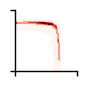

In [11]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    # Example threshold and discrete levels
    fig, ax = plt.subplots(1, 1, figsize=(0.8, 0.8))
    threshold = 0.001 * np.max(probs.numpy())
    levels = np.linspace(0.001 * np.max(probs.numpy()), np.max(probs.numpy()), 5)
    
    extent = [-18.4, -6.9, -18.4, -4.6]

    # Create a colormap and normalize it
    cmap = plt.get_cmap("Reds", len(levels) - 1)
    cmap.set_under(color=(1, 1, 1, 0))  # fully transparent for values below threshold

    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

    # Plot
    ax.imshow(
        probs.numpy(),
        extent=extent,
        origin='lower',
        aspect='auto',
        interpolation='none',
        cmap=cmap,
        norm=norm,
    )
    _ = ax.set_xticks([-18.4, -6.9])
    _ = ax.set_xlim([-18.4, -6.9])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([-18.4, -4.6])
    _ = ax.set_ylim([-18.4, -4.6])
    _ = ax.set_yticklabels([])
    
    plt.savefig("../svg/panel_h2.svg", bbox_inches="tight", transparent=True)
    plt.show()

# Second row

### Panel f

Panel f shows a posterior predictive.

In [7]:
_ = torch.manual_seed(0)
num_samples = 1
posterior_samples = posterior.sample((num_samples,), x=x_o)

p1 = create_prior()
pars = p1.sample((1,))
column_names = pars.columns
parameter_set_pd = pd.DataFrame(np.asarray(posterior_samples), columns=column_names)

all_stats = []
for i in range(num_samples):
    simulation_output = simulate(parameter_set_pd.loc[i], seed=1)
#     with mpl.rc_context(fname="../../../.matplotlibrc"):
#         fig, ax = plt.subplots(1, 2, figsize=(2, 1))


Drawing 1 posterior samples for 1 observations: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.95it/s]


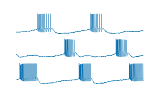

In [9]:
offset = 72_000
t = 2.5  # seconds
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1))
    for i in range(3):
        ax.plot(simulation_output["voltage"][i, offset:offset+int(t * 40 * 1000)] - 150.0 * i, color=colors["x"], linewidth=0.2)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig("../svg/panel_f.svg", bbox_inches="tight", transparent=True)
    plt.show()

### Panel g

Panel g shows expected coverage

In [12]:
from plotting import _sbc_rank_plot

with open("../results/analysis/ensemble_exp_cov_ranks.pkl", "rb") as handle:
    ranks = pickle.load(handle)
with open("../results/analysis/ensemble_exp_cov_dap_samples.pkl", "rb") as handle:
    dap_samples = pickle.load(handle)
    
individual_ranks = []
for individual in range(5):
    with open(f"../results/analysis/individual_{individual}_exp_cov_ranks.pkl", "rb") as handle:
        new_ranks = pickle.load(handle)
    individual_ranks.append(new_ranks)
individual_ranks = torch.cat(individual_ranks, axis=1)
ranks = torch.cat([ranks, individual_ranks], axis=1)

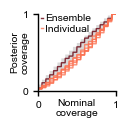

In [13]:
num_posterior_samples = 1_000

with mpl.rc_context(fname="../../../.matplotlibrc"):
    individual_col = colors["theta_shades"][1]
    fig, ax = _sbc_rank_plot(
        ranks,
        num_posterior_samples,
        plot_type="cdf",
        num_bins=20,
        figsize=(1, 1),
        colors=[colors["theta_shades"][4], individual_col, individual_col, individual_col, individual_col, individual_col],
    )
    ax.set_xticks([0, 20])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1])
    ax.set_xticklabels([0, 1])
#     ax.set_xlabel("Posterior rank", labelpad=-3)
#     ax.set_ylabel("Empirical CDF", labelpad=-1)
    _ = ax.set_xlabel("Nominal\ncoverage", labelpad=-8)
    _ = ax.set_ylabel("Posterior\ncoverage", labelpad=-5)
    _ = ax.legend(
        ["Ensemble", "Individual"],
        loc="upper right",
        bbox_to_anchor=[0.8, 1.12, 0.0, 0.0],
        handlelength=0.2,
        handletextpad=0.2,
        labelspacing=0.1,
    )
    plt.savefig("../svg/panel_g.svg", bbox_inches="tight", transparent=True)
    plt.show()

### Panel h

Panel h shows SBC

In [14]:
with open("../results/analysis/ensemble_sbc_ranks.pkl", "rb") as handle:
    ranks = pickle.load(handle)
with open("../results/analysis/ensemble_sbc_dap_samples.pkl", "rb") as handle:
    dap_samples = pickle.load(handle)

num_posterior_samples = 1_000

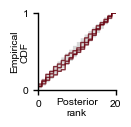

In [15]:
dims = 3
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = _sbc_rank_plot(
        ranks[:, :dims],
        num_posterior_samples,
        num_bins=20,
        figsize=(1, 1),
        colors=[colors["theta_shades"][4] for _ in range(dims)],
    )
    ax.set_xticks([0, 20])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1])
    ax.set_xlabel("Posterior\nrank", labelpad=-8)
    ax.set_ylabel("Empirical\nCDF", labelpad=-5)
    plt.savefig("../svg/panel_h.svg", bbox_inches="tight", transparent=True)
    plt.show()

### Panel i

Panel i shows TARP

In [16]:
from sbi.diagnostics import check_tarp
from sbi.analysis.plot import plot_tarp

In [17]:
with open("../results/analysis/ensemble_tarp_ecp.pkl", "rb") as handle:
    ecp = pickle.load(handle)
with open("../results/analysis/ensemble_tarp_dap_alpha.pkl", "rb") as handle:
    alpha = pickle.load(handle)

/var/folders/kv/39t9blx569l5_sxxzx89vb3c0000gn/T/ipykernel_71569/1547871789.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


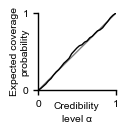

In [18]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.0, 1.0))
    ax.plot(alpha, alpha, color="gray")
    ax.plot(alpha, ecp, color="k")
    ax.set_xlabel("Credibility\nlevel "+r"$\alpha$", labelpad=-5)
    ax.set_ylabel("Expected coverage\nprobability", labelpad=-5)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.legend(
        loc="upper right",
        bbox_to_anchor=[1.0, 0.4, 0.0, 0.0],
        labelspacing=0.1,
        handlelength=0.5,
        handletextpad=0.1,
    )
    plt.savefig("../svg/panel_i.svg", bbox_inches="tight", transparent=True)
    plt.show()

### Panel j

Panel j shows L-C2ST

In [19]:
with open("../results/analysis/lc2st_net.pkl", "rb") as handle:
    lc2st = pickle.load(handle)

In [20]:
_ = torch.manual_seed(0)

# Note: x_o must have a batch-dimension. I.e. `x_o.shape == (1, observation_shape)`.
post_samples_star = posterior.sample((10_000,), x=x_o)
probs_data, scores_data = lc2st.get_scores(
    theta_o=post_samples_star,
    x_o=torch.as_tensor(x_o),
    return_probs=True,
    trained_clfs=lc2st.trained_clfs
)
probs_null, scores_null = lc2st.get_statistics_under_null_hypothesis(
    theta_o=post_samples_star,
    x_o=torch.as_tensor(x_o),
    return_probs=True,
)

conf_alpha = 0.05
p_value = lc2st.p_value(post_samples_star, torch.as_tensor(x_o).unsqueeze(0))
reject = lc2st.reject_test(post_samples_star, torch.as_tensor(x_o).unsqueeze(0), alpha=conf_alpha)

Drawing 1951 posterior samples for 1 observations: 1994it [00:00, 19213.36it/s]                                                                                    
Drawing 2029 posterior samples for 1 observations: 2126it [00:00, 23135.61it/s]                                                                                    
Drawing 1971 posterior samples for 1 observations: 2048it [00:00, 24068.66it/s]                                                                                    
Drawing 2035 posterior samples for 1 observations: 2103it [00:00, 27059.03it/s]                                                                                    
Drawing 2014 posterior samples for 1 observations: 2065it [00:00, 27297.89it/s]                                                                                    


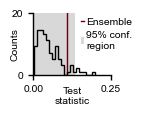

In [21]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.0, 0.8))
    quantiles = np.quantile(scores_null, [0, 1-conf_alpha])
    
    ax.axvline(scores_data, color=colors["theta_shades"][4], label="Observed")
    ax.fill_betweenx(np.linspace(0, 20, 20), quantiles[0] * np.ones(20), quantiles[1] * np.ones(20), color="gray", alpha=0.3, edgecolor=None)
    ax.hist(scores_null, bins=20, density=True, alpha=1.0, label="Null", facecolor="k", color="k", histtype="step")
    ax.set_xlabel("Test\nstatistic", labelpad=-5)
    ax.set_ylabel("Counts", labelpad=-5)
    ax.set_yticks([0, 20])
    ax.set_ylim([0, 20])
    ax.set_xticks([0, 0.25])
    ax.set_xlim([0, 0.25])
#     ax.set_title(f"p-value = {p_value:.2f}")
    ax.legend(
        ["Ensemble", "95% conf.\nregion"],
        loc="upper right",
        bbox_to_anchor=[1.4, 1.08, 0.0, 0.0],
        handlelength=0.3,
        handletextpad=0.2,
        labelspacing=0.4,
    )
    plt.savefig("../svg/panel_j.svg", bbox_inches="tight", transparent=True)
    plt.show()

In [22]:
# from sbi.analysis.plot import pp_plot_lc2st

# pp_plot_lc2st(
#     probs=[probs_data],
#     probs_null=probs_null,
#     conf_alpha=0.05,
#     labels=["Classifier probabilities \n on observed data"],
#     colors=["red"],
# )

### Assemble figure

In [10]:
import time
import IPython.display as IPd
from svgutils.compose import *


def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

svg_scale = 1.25  # set this to 1.334 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '10pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_normal = {'size': '7pt', 'font': 'Arial'}

f = Figure(
    "18.0cm",
    "6.3cm",
    
    Panel(
        SVG("../svg/panel_a.svg").scale(4.2).move(0, 14),
        Text("a", 0, 2.0, **kwargs_text),
        Text("Pyloric network", 15, 2.0, **kwargs_text_normal),
        Text("w/ 31 parameters", 13, 12.0, **kwargs_text_normal),
    ).move(0, 10),
    
    Panel(
        SVG("../svg/panel_b_small.svg").scale(1.0).move(5, 6),
        Text("b", 3, 2.0, **kwargs_text),
        Text("Observation", 60, 2.0, **kwargs_text_normal),
    ).move(118, 10),
    
    Panel(
        SVG("../svg/panel_ensemble.svg").scale(1.0).move(0, 13),
        Text("c", -5, 2.0, **kwargs_text),
        Text("Ensemble of five NPE models", 7, 2.0, **kwargs_text_normal),
    ).move(305, 10),
    
    Panel(
        SVG("../svg/panel_g.svg").scale(svg_scale).move(0, -3),
        SVG("../svg/panel_h.svg").scale(svg_scale).move(95, -3),
        Text("d", 12, 2.0, **kwargs_text),
        Text("Global validation", 65, 2.0, **kwargs_text_normal),
        Text("SBC", 135, 17.0, **kwargs_text_normal),
    ).move(475, 10),
    
    Panel(
        SVG("../svg/panel_j.svg").scale(svg_scale).move(-8, 0),
        Text("e", 0, 2.0, **kwargs_text),
        Text("L-C2ST", 40, 2.0, **kwargs_text_normal),
    ).move(0, 135),
    
    Panel(
        SVG("../svg/panel_f.svg").scale(svg_scale).move(-5, 10),
        Text("f", 0, 2.0, **kwargs_text),
        Text("Posterior predictive", 26, 2.0, **kwargs_text_normal),
    ).move(130, 135),
    
    Panel(
        SVG("../svg/panel_d.svg").scale(svg_scale).move(0, 0),
        SVG("../svg/panel_d_sketchup.svg").scale(svg_scale).move(113.5, 34.5),
        Text("g", 3, 2.0, **kwargs_text),
        Text("Posterior marginals of 31 parameters", 36, 2.0, **kwargs_text_normal),
    ).move(280, 135),
    
    Panel(
        SVG("../svg/panel_h1.svg").scale(svg_scale).move(0, 6),
        SVG("../svg/panel_h2.svg").scale(svg_scale).move(105, 9),
        Text("h", 3, 2.0, **kwargs_text),
        Text("2D Posterior", 70, 2.0, **kwargs_text_normal),
        Text("Marginal", 40, 12.0, **kwargs_text_normal),
        Text("Conditional", 115, 12.0, **kwargs_text_normal),
    ).move(505, 135),
)

!mkdir -p fig
f.save("../fig/fig8.svg")
svg("../fig/fig8.svg")